# Saliency and Grad-CAM Examples

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/computer-vision-with-embedded-machine-learning/blob/master/2.3.1%20-%20CNN%20Visualizations/ei_saliency_and_grad_cam.ipynb)

Import a trained model (.zip file) from Edge Impulse and copy in post-processed features of a single sample image. Run the notebook to see a saliency map and Grad-CAM heatmap.

Saliency maps highlight which pixels in the input image were most important (i.e. most salient) in the decision making process.

Grad-CAM looks at the output feature map of the final convolution layer to figure out which areas of the image were the most important in the decision making process.

Author: EdgeImpulse, Inc.<br>
Date: June 19, 2021<br>
License: [Apache-2.0](apache.org/licenses/LICENSE-2.0)<br>

In [1]:
import numpy as np

import tensorflow as tf
from keras.models import load_model
from keras import activations, layers, models, backend

import cv2

import matplotlib.pyplot as plt

In [2]:
### Unzip model

# Change this based on your .zip model filename
model_zip_path = "/content/ei-electronic-components-cnn-nn-classifier-tensorflow-savedmodel-model.zip"

# Unzip in place
!unzip "{model_zip_path}"

Archive:  /content/ei-electronic-components-cnn-nn-classifier-tensorflow-savedmodel-model.zip
replace saved_model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
### Settings

# Image resolution
width = 28
height = 28

# Labels
labels = ["background", "capacitor", "diode", "led", "resistor"]

# Paste ground processed features from Edge Impulse and set ground-truth label
img = [0.5536, 0.5497, 0.5702, 0.5719, 0.5608, 0.5702, 0.5758, 0.5719, 0.5758, 0.5758, 0.5758, 0.5742, 0.5781, 0.5804, 0.5827, 0.5815, 0.5811, 0.5792, 0.5820, 0.5838, 0.5850, 0.5834, 0.5815, 0.5845, 0.5827, 0.5799, 0.5781, 0.5735, 0.5497, 0.5663, 0.5758, 0.5758, 0.5696, 0.5719, 0.5758, 0.5719, 0.5735, 0.5758, 0.5765, 0.5804, 0.5834, 0.5834, 0.5834, 0.5822, 0.5845, 0.5850, 0.5862, 0.5822, 0.5815, 0.5822, 0.5845, 0.5815, 0.5845, 0.5850, 0.5850, 0.5776, 0.5663, 0.5758, 0.5758, 0.5719, 0.5735, 0.5758, 0.5742, 0.5776, 0.5792, 0.5804, 0.5827, 0.5834, 0.5850, 0.5875, 0.5880, 0.5899, 0.5834, 0.5875, 0.5915, 0.5880, 0.5891, 0.5843, 0.5840, 0.5859, 0.5845, 0.5822, 0.5845, 0.5840, 0.5702, 0.5758, 0.5719, 0.5758, 0.5742, 0.5719, 0.5765, 0.5827, 0.5850, 0.5834, 0.5834, 0.5811, 0.5977, 0.6049, 0.6026, 0.5967, 0.5900, 0.5991, 0.6032, 0.5829, 0.5886, 0.5863, 0.5838, 0.5822, 0.5811, 0.5850, 0.5854, 0.5820, 0.5696, 0.5735, 0.5719, 0.5719, 0.5730, 0.5765, 0.5827, 0.5811, 0.5811, 0.5862, 0.5834, 0.5922, 0.6072, 0.6055, 0.6055, 0.6044, 0.6049, 0.6072, 0.6032, 0.5931, 0.5931, 0.5850, 0.5845, 0.5804, 0.5822, 0.5843, 0.5865, 0.5831, 0.5735, 0.5719, 0.5758, 0.5822, 0.5815, 0.5827, 0.5834, 0.5850, 0.5954, 0.6032, 0.6028, 0.6072, 0.6049, 0.6032, 0.6037, 0.6055, 0.6055, 0.6055, 0.6049, 0.6049, 0.6026, 0.5905, 0.5815, 0.5850, 0.5838, 0.5854, 0.5870, 0.5829, 0.5742, 0.5735, 0.5758, 0.5834, 0.5850, 0.5850, 0.5815, 0.5961, 0.6083, 0.6049, 0.6049, 0.6032, 0.6032, 0.6049, 0.6055, 0.6037, 0.6055, 0.6072, 0.6032, 0.6032, 0.6049, 0.5958, 0.5891, 0.5820, 0.5842, 0.5956, 0.5991, 0.5849, 0.5735, 0.5735, 0.5742, 0.5827, 0.5811, 0.5811, 0.5815, 0.5981, 0.6049, 0.6009, 0.6055, 0.6078, 0.6049, 0.6055, 0.6072, 0.6072, 0.6049, 0.6095, 0.6101, 0.6072, 0.6009, 0.6026, 0.6049, 0.5970, 0.5928, 0.6049, 0.6067, 0.5894, 0.5758, 0.5735, 0.5804, 0.5811, 0.5866, 0.5917, 0.5854, 0.5975, 0.6049, 0.6055, 0.6055, 0.6072, 0.6072, 0.6095, 0.6037, 0.6049, 0.6072, 0.6136, 0.6136, 0.6124, 0.6060, 0.6078, 0.6078, 0.6095, 0.6049, 0.6032, 0.6072, 0.5993, 0.5804, 0.5822, 0.5850, 0.5811, 0.5863, 0.6014, 0.6067, 0.6067, 0.6055, 0.6055, 0.6067, 0.6067, 0.6044, 0.6067, 0.6067, 0.6090, 0.6136, 0.6136, 0.6120, 0.6081, 0.6097, 0.6124, 0.6136, 0.6083, 0.6037, 0.6067, 0.6055, 0.6072, 0.5822, 0.5850, 0.5850, 0.5811, 0.5871, 0.6021, 0.6044, 0.5998, 0.5975, 0.6014, 0.5975, 0.5958, 0.5993, 0.6051, 0.5993, 0.6062, 0.6101, 0.6122, 0.6306, 0.6428, 0.6287, 0.6150, 0.6032, 0.6044, 0.6032, 0.6060, 0.6049, 0.6009, 0.5850, 0.5822, 0.5822, 0.5834, 0.5850, 0.5862, 0.6007, 0.6255, 0.6336, 0.6151, 0.6309, 0.6505, 0.6334, 0.6336, 0.6542, 0.6572, 0.6388, 0.6270, 0.5476, 0.4665, 0.5099, 0.5876, 0.6102, 0.6032, 0.6044, 0.6067, 0.6067, 0.5986, 0.5799, 0.5781, 0.5827, 0.5850, 0.5815, 0.5862, 0.5517, 0.3781, 0.2192, 0.3420, 0.4005, 0.4060, 0.4991, 0.5137, 0.4310, 0.4207, 0.4463, 0.3916, 0.2547, 0.0898, 0.2204, 0.3795, 0.5794, 0.6131, 0.6062, 0.6078, 0.6055, 0.6009, 0.5757, 0.5780, 0.5803, 0.5820, 0.5805, 0.6075, 0.3876, 0.1835, 0.0399, 0.2985, 0.2197, 0.0139, 0.1731, 0.3261, 0.1489, 0.1767, 0.3422, 0.3198, 0.3476, 0.5168, 0.5582, 0.3599, 0.4792, 0.6490, 0.6372, 0.6266, 0.6157, 0.6153, 0.6008, 0.5988, 0.5937, 0.5815, 0.5922, 0.5418, 0.3256, 0.2231, 0.1299, 0.3781, 0.4072, 0.3059, 0.3375, 0.3961, 0.2047, 0.2526, 0.3623, 0.3195, 0.3432, 0.4702, 0.5333, 0.3945, 0.3316, 0.4202, 0.4269, 0.5429, 0.6038, 0.6160, 0.3374, 0.3295, 0.3386, 0.3707, 0.3733, 0.2852, 0.2560, 0.2133, 0.0585, 0.2619, 0.1949, 0.0106, 0.1203, 0.3086, 0.1467, 0.1673, 0.3037, 0.2887, 0.2583, 0.1448, 0.2198, 0.3257, 0.3154, 0.4693, 0.4956, 0.5046, 0.5136, 0.5140, 0.3459, 0.3465, 0.3447, 0.3461, 0.3315, 0.2495, 0.2328, 0.1714, 0.0491, 0.2280, 0.2032, 0.0356, 0.1313, 0.2869, 0.1546, 0.1676, 0.2735, 0.2596, 0.2374, 0.1442, 0.2082, 0.3044, 0.3166, 0.4060, 0.4084, 0.3964, 0.3924, 0.3882, 0.4320, 0.4375, 0.4345, 0.4321, 0.4292, 0.3104, 0.2058, 0.1785, 0.0831, 0.2038, 0.2002, 0.0634, 0.1012, 0.1788, 0.1286, 0.1219, 0.1668, 0.1766, 0.2123, 0.1878, 0.1933, 0.2740, 0.5056, 0.5809, 0.5736, 0.5758, 0.5742, 0.5726, 0.6038, 0.6038, 0.6072, 0.6065, 0.6158, 0.5636, 0.2647, 0.1153, 0.0912, 0.1179, 0.1702, 0.1787, 0.2035, 0.2151, 0.2285, 0.2401, 0.2233, 0.1741, 0.1466, 0.1593, 0.2002, 0.3985, 0.6271, 0.6503, 0.6452, 0.6270, 0.6203, 0.6215, 0.5783, 0.5783, 0.5806, 0.5819, 0.5819, 0.5877, 0.5240, 0.3872, 0.3661, 0.4013, 0.5094, 0.5794, 0.5998, 0.6111, 0.6070, 0.6139, 0.6102, 0.5721, 0.5139, 0.5248, 0.5613, 0.6043, 0.6180, 0.6284, 0.6268, 0.6124, 0.6124, 0.6124, 0.5838, 0.5838, 0.5834, 0.5850, 0.5815, 0.5896, 0.6131, 0.6318, 0.6329, 0.6341, 0.6309, 0.6169, 0.6125, 0.6213, 0.6187, 0.6203, 0.6234, 0.6278, 0.6340, 0.6340, 0.6296, 0.6175, 0.6136, 0.6136, 0.6136, 0.6147, 0.6118, 0.6078, 0.5799, 0.5850, 0.5850, 0.5811, 0.5850, 0.6032, 0.6032, 0.6005, 0.6097, 0.6097, 0.6074, 0.6090, 0.6099, 0.6173, 0.6101, 0.6124, 0.6236, 0.6215, 0.6167, 0.6136, 0.6148, 0.6136, 0.6141, 0.6164, 0.6164, 0.6129, 0.6136, 0.6118, 0.5735, 0.5799, 0.5850, 0.5811, 0.5836, 0.5998, 0.6072, 0.6055, 0.6078, 0.6083, 0.6055, 0.6072, 0.6096, 0.6115, 0.6060, 0.6118, 0.6159, 0.6136, 0.6129, 0.6160, 0.6164, 0.6164, 0.6136, 0.6141, 0.6164, 0.6124, 0.6095, 0.6072, 0.5742, 0.5735, 0.5804, 0.5834, 0.5827, 0.5878, 0.5942, 0.6072, 0.6095, 0.6032, 0.6049, 0.6037, 0.6067, 0.6067, 0.6044, 0.6106, 0.6152, 0.6106, 0.6101, 0.6141, 0.6141, 0.6141, 0.6152, 0.6129, 0.6129, 0.6118, 0.6037, 0.6049, 0.5719, 0.5719, 0.5758, 0.5827, 0.5845, 0.5788, 0.5822, 0.5903, 0.5998, 0.6072, 0.6032, 0.6055, 0.6072, 0.6060, 0.6037, 0.6067, 0.6072, 0.6049, 0.6101, 0.6147, 0.6141, 0.6106, 0.6136, 0.6164, 0.6072, 0.6037, 0.6072, 0.6072, 0.5758, 0.5758, 0.5719, 0.5742, 0.5769, 0.5758, 0.5804, 0.5811, 0.5862, 0.5926, 0.6026, 0.6072, 0.6032, 0.6044, 0.6055, 0.6049, 0.6072, 0.6032, 0.6049, 0.6118, 0.6147, 0.6090, 0.6049, 0.6078, 0.6055, 0.6049, 0.6055, 0.6049, 0.5592, 0.5719, 0.5758, 0.5735, 0.5742, 0.5723, 0.5758, 0.5827, 0.5742, 0.5776, 0.5926, 0.6032, 0.6072, 0.6037, 0.6072, 0.6055, 0.6055, 0.6049, 0.6009, 0.6032, 0.6095, 0.6095, 0.6032, 0.6049, 0.6072, 0.6055, 0.6049, 0.6072, 0.5497, 0.5536, 0.5608, 0.5719, 0.5758, 0.5719, 0.5758, 0.5811, 0.5781, 0.5746, 0.5811, 0.5905, 0.6014, 0.6032, 0.6055, 0.6049, 0.6032, 0.6049, 0.6032, 0.6055, 0.6049, 0.6060, 0.6072, 0.6009, 0.6032, 0.6072, 0.6055, 0.6049]
true_idx = 4  # Resistor

# You probably don't need to change this
model_dir = "/content/saved_model"

In [4]:
### Load model file
model = load_model("saved_model")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
y_pred (Dense)               (None, 5)                 3

Actual label: resistor


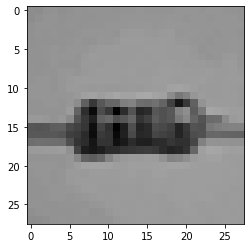

In [5]:
### Reshape image 

# Convert features to 2D Numpy array
img_reshape = np.reshape(np.array(img), (height, width))

# Show the ground-truth label
print("Actual label:", labels[true_idx])

# Display image (make sure we're looking at the right thing)
plt.imshow(img_reshape, cmap='gray', vmin=0.0, vmax=1.0)

In [6]:
### The Keras model expects images in a 4D array with dimensions (sample, height, width, channel)

# Add extra dimension to the image (placeholder for color channels)
img_0 = img_reshape.reshape(img_reshape.shape + (1,))

# Keras expects more than one image (in Numpy array), so convert image(s) to such array
images = np.array([img_0])

# Print dimensions of inference input
print(images.shape)

(1, 28, 28, 1)


In [7]:
### Do a forward pass (inference) with the test image and print the predicted probabilities

# Inference
preds = model.predict(images)

# Print out predictions
for i, pred in enumerate(preds[0]):
  print(labels[i] + ": " + str(pred))

background: 5.500098e-06
capacitor: 0.00023299255
diode: 0.20903587
led: 0.002536503
resistor: 0.78818905


In [8]:
### For either algorithm, we need to remove the Softmax activation function of the last layer
model.layers[-1].activation = None

## Saliency Map

In [9]:
### Based on: https://github.com/keisen/tf-keras-vis/blob/master/tf_keras_vis/saliency.py
def get_saliency_map(img_array, model, class_idx):

  # Gradient calculation requires input to be a tensor
  img_tensor = tf.convert_to_tensor(img_array)

  # Do a forward pass of model with image and track the computations on the "tape"
  with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:

    # Compute (non-softmax) outputs of model with given image
    tape.watch(img_tensor)
    outputs = model(img_tensor, training=False)

    # Get score (predicted value) of actual class
    score = outputs[:, true_idx]

  # Compute gradients of the loss with respect to the input image
  grads = tape.gradient(score, img_tensor)  

  # Finds max value in each color channel of the gradient (should be grayscale for this demo)
  grads_disp = [np.max(g, axis=-1) for g in grads]

  # There should be only one gradient heatmap for this demo
  grad_disp = grads_disp[0]

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  grad_disp = tf.abs(grad_disp)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(grad_disp)
  heatmap_max = np.max(grad_disp)
  heatmap = (grad_disp - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [10]:
### Generate saliency map for the given input image
saliency_map = get_saliency_map(images, model, true_idx)

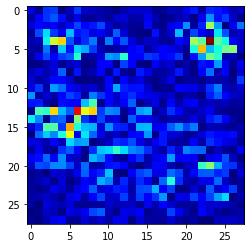

In [11]:
### Draw map
plt.imshow(saliency_map, cmap='jet', vmin=0.0, vmax=1.0)

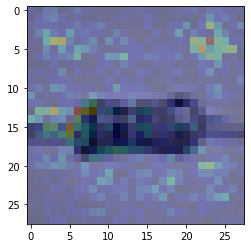

In [12]:
### Overlay the saliency map on top of the original input image
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(saliency_map, cmap='jet', alpha=0.25)

## Grad-CAM

In [13]:
### This function comes from https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

  # First, we create a model that maps the input image to the activations
  # of the last conv layer as well as the output predictions
  grad_model = tf.keras.models.Model(
      [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
  )

  # Then, we compute the gradient of the top predicted class for our input image
  # with respect to the activations of the last conv layer
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # This is the gradient of the output neuron (top predicted or chosen)
  # with regard to the output feature map of the last conv layer
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # This is a vector where each entry is the mean intensity of the gradient
  # over a specific feature map channel
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # We multiply each channel in the feature map array
  # by "how important this channel is" with regard to the top predicted class
  # then sum all the channels to obtain the heatmap class activation
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # The absolute value of the gradient shows the effect of change at each pixel
  # Source: https://christophm.github.io/interpretable-ml-book/pixel-attribution.html
  heatmap = tf.abs(heatmap)

  # Normalize to between 0 and 1 (use epsilon, a very small float, to prevent divide-by-zero error)
  heatmap_min = np.min(heatmap)
  heatmap_max = np.max(heatmap)
  heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + tf.keras.backend.epsilon())

  return heatmap.numpy()

In [14]:
### We need to tell Grad-CAM where to find the last convolution layer

# Print out the layers in the model
for layer in model.layers:
  print(layer, layer.name)

# Go backwards through the model to find the last convolution layer
last_conv_layer = None
for layer in reversed(model.layers):
  if isinstance(layer, layers.convolutional.Conv):
    last_conv_layer = layer.name
    break

# Give a warning if the last convolution layer could not be found
if last_conv_layer is not None:
  print("Last convolution layer found:", last_conv_layer)
else:
  print("ERROR: Last convolution layer could not be found. Do not continue.")

<keras.layers.convolutional.Conv2D object at 0x7f64d37eef10> conv2d
<keras.layers.pooling.MaxPooling2D object at 0x7f64d3121990> max_pooling2d
<keras.layers.convolutional.Conv2D object at 0x7f64d01b8410> conv2d_1
<keras.layers.pooling.MaxPooling2D object at 0x7f64d01b9ad0> max_pooling2d_1
<keras.layers.core.Flatten object at 0x7f64d01bd710> flatten
<keras.layers.core.Dropout object at 0x7f64d01bdd90> dropout
<keras.layers.core.Dense object at 0x7f64d014c750> y_pred
Last convolution layer found: conv2d_1


In [15]:
### Generate class activation heatmap
heatmap = make_gradcam_heatmap(images, model, last_conv_layer)

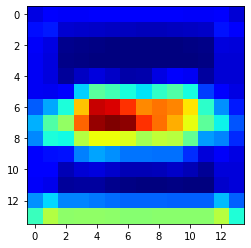

In [16]:
### Draw map
plt.imshow(heatmap, cmap='jet', vmin=0.0, vmax=1.0)

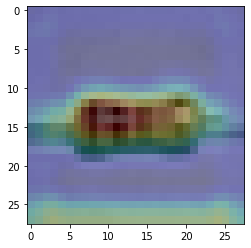

In [17]:
### Overlay the saliency map on top of the original input image

# The heatmap is a lot smaller than the original image, so we upsample it
big_heatmap = cv2.resize(heatmap, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

# Draw original image with heatmap superimposed over it
idx = 0
ax = plt.subplot()
ax.imshow(images[idx,:,:,0], cmap='gray', vmin=0.0, vmax=1.0)
ax.imshow(big_heatmap, cmap='jet', alpha=0.25)